<a href="https://colab.research.google.com/github/Miragecore/SandBox/blob/devel/Colab/Stitching/TestCode2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os;
root_path = '/content/drive/MyDrive/SandBox/Stitch/earring'

os.chdir(root_path);

print(os.getcwd())

/content/drive/MyDrive/SandBox/Stitch/earring


In [3]:
from IPython.display import Image, display

In [4]:
# Some example images
image_files = [
    'earring_1.jpg',
    'earring_2.jpg',
    'earring_3.jpg']
'''
for image_file in image_files:
    print(f"\nDisplaying image: {image_file}")
    display(Image(filename=f"{image_file}"))
'''

'\nfor image_file in image_files:\n    print(f"\nDisplaying image: {image_file}")\n    display(Image(filename=f"{image_file}"))\n'

In [5]:
import cv2, numpy as np
#
from google.colab.patches import cv2_imshow

img1 = cv2.imread(image_files[0])
img2 = cv2.imread(image_files[1])
img3 = cv2.imread(image_files[2])

In [98]:
def match(kp1, desc1, kp2, desc2, method='RANSAC', k_ratio = 0.75):
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
    #matches = []

    print('match kp' + str(len(kp1)) + '-2-' + str(len(kp2)))
    if method == 'RANSAC':
      matches = matcher.knnMatch(desc1, desc2,k=2)

      print('mathces' + str(len(matches)))
      # 매칭 결과를 거리기준 오름차순으로 정렬 ---③
      #matches = sorted(matches, key=lambda x:x.distance)

      good_matches = [first for first,second in matches \
                     if first.distance < second.distance * k_ratio]
      # 매칭점으로 원근 변환 및 영역 표시 ---⑤
      src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
      dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

      print(str(len(src_pts)) + str(len(dst_pts)))
      # RANSAC으로 변환 행렬 근사 계산 ---⑥
      H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

      return H, good_matches, mask

    elif method =='knn':
      matches = matcher.knnMatch(desc2,desc1, k=2)

      good_matches = [first for first,second in matches \
                    if first.distance < second.distance * k_ratio]
      # 좋은 매칭점의 queryIdx로 원본 영상의 좌표 구하기 ---③
      src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ])
      # 좋은 매칭점의 trainIdx로 대상 영상의 좌표 구하기 ---④
      dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ])
      # 원근 변환 행렬 구하기 ---⑤
      H, mask = cv2.findHomography(src_pts, dst_pts)

      return H, good_matches, mask


In [103]:
def warpPano(img1, img2, isDraw = False):
    detector = cv2.ORB_create()
    #detector = cv2.xfeatures2d.SIFT_create(400)
    # find the keypoints and descriptors with SIFT
    gray1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    ret1, mask1 = cv2.threshold(gray1,1,255,cv2.THRESH_BINARY)
    kp1, descriptors1 = detector.detectAndCompute(gray1,mask1)

    gray2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    ret2, mask2 = cv2.threshold(gray2,1,255,cv2.THRESH_BINARY)
    kp2, descriptors2 = detector.detectAndCompute(gray2,mask2)

    #keypoints1Im = cv2.drawKeypoints(img1, kp1, outImage = cv2.DRAW_MATCHES_FLAGS_DEFAULT, color=(0,0,255))
    #keypoints2Im = cv2.drawKeypoints(img2, kp2, outImage = cv2.DRAW_MATCHES_FLAGS_DEFAULT, color=(0,0,255))

    print('kp1' + str(len(kp1)))
    H, matches, m_mask = match(kp1, descriptors1, kp2, descriptors2)

    if isDraw :
      m_mask = m_mask.ravel().tolist()
      res = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, \
                            matchesMask=m_mask, \
                            flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
      cv2_imshow(res)

    h1,w1 = img2.shape[:2]
    h2,w2 = img1.shape[:2]

    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)

    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)

    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

    result = cv2.warpPerspective(img1, Ht.dot(H), (xmax-xmin, ymax-ymin))
    resizedB = np.zeros((result.shape[0], result.shape[1], 3), np.uint8)
    resizedB[t[1]:t[1]+h1,t[0]:w1+t[0]] = img2

    # Now create a mask of logo and create its inverse mask also
    # Create mask warped img2 region
    img1gray = cv2.cvtColor(result,cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img1gray, 0, 255, cv2.THRESH_BINARY)

    kernel = np.ones((5,5),np.uint8)
    k1 = (kernel == 1).astype('uint8')
    mask = cv2.erode(mask, k1, borderType=cv2.BORDER_CONSTANT)

    # img1 Region Mask
    mask_inv = cv2.bitwise_not(mask)

    # Create masked img1
    difference = cv2.bitwise_or(resizedB, resizedB, mask=mask_inv)

    # Create amsked img2
    result2 = cv2.bitwise_and(result, result, mask=mask)

    result = cv2.add(result2, difference)

    #cv2_imshow(result)

    return result

kp1376
match kp376-2-322
mathces376
1212


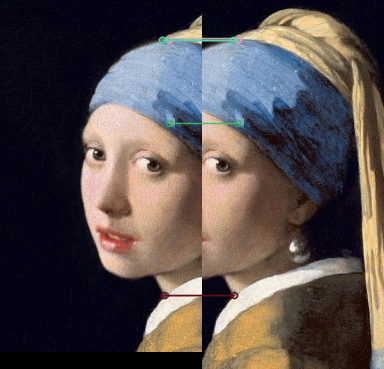

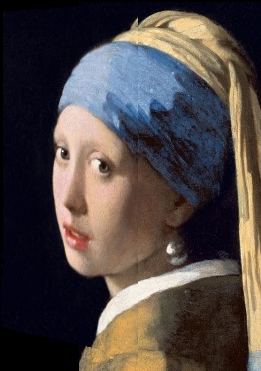

kp1446
match kp446-2-326
mathces446
2323


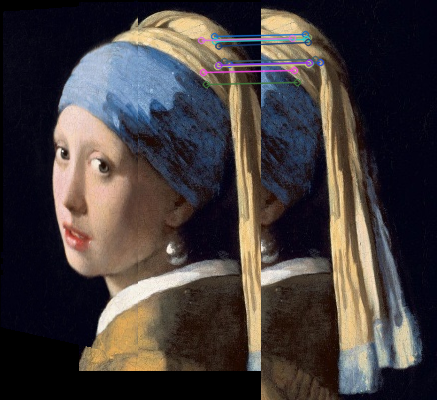

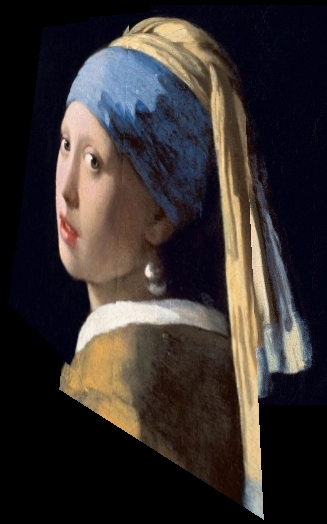

In [105]:
warped = warpPano(img1, img2, True)
cv2_imshow(warped)

warped = warpPano(warped, img3, True)
cv2_imshow(warped)